In [90]:
import numpy as np
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf

# returns number of each nucleotide in a sequence
def nuc_count(seq):
    a, t, c, g = 0, 0, 0, 0

    for letter in seq:
        if letter == 'a':
            a+=1
        elif letter == 't':
            t+=1
        elif letter == 'c':
            c+=1
        else:
            g+=1

    return a, t, c, g

# translates seq from letters to corresponding number sequence and returns as a list
def process_seq(seq):
    dictionary = {'a': 1, 't': 2, 'c': 3, 'g': 4}
    translated = []
    for char in seq:
        if char in dictionary:
            translated.append(dictionary[char])
        else:
            translated.append(0)

    return translated

# returns a list of dictionaries of sequences and their descriptions given a fasta file
# 0 for positive and 1 for negative
def to_list(file, pos_neg):
    if pos_neg == 0 or pos_neg == 1:
        fasta = SeqIO.parse(file, "fasta")

        fasta_dict = []
        for record in fasta:
            seq_description = record.id.split('|')
            seq = str(record.seq)
            a, t, c, g = nuc_count(seq)

            fasta_dict.append({'seq_id': seq_description[0], 'seq_name': seq_description[1],
                               'sequence': seq, 'classifier': pos_neg,
                               'a_count': a, 't_count': t, 'c_count': c, 'g_count': g})

    return fasta_dict

In [91]:
# combine data files
pos = to_list("COI_Positives_360.fa", 0)
neg = to_list("negative_.fasta.fa", 1)
data = pos + neg

all_data = pd.DataFrame(data, columns=['seq_id', 'seq_name', 'sequence', 'classifier',
                                       'a_count','t_count', 'c_count', 'g_count'])

# only numerical data
num_nuc = all_data[['a_count','t_count', 'c_count', 'g_count']]
# num_nuc = shuffle(num_nuc)
print(num_nuc.head)

# seq as single str
seq_df = all_data['sequence']

seq_data = []
# splitting seq up into list of chars
for seq in seq_df:
    seq_data.append(process_seq(seq))

# dataframe where each nucleotide is a feature
sep_seq_df = pd.DataFrame(seq_data)

<bound method NDFrame.head of        a_count  t_count  c_count  g_count
0           86      160       33       81
1           76      162       34       88
2           75      161       31       93
3           76      164       26       94
4           76      153       37       94
...        ...      ...      ...      ...
12861       85      106       64      105
12862       65       65      106      124
12863       58       56      122      124
12864       79       72       93      116
12865       57       57      121      125

[12866 rows x 4 columns]>


In [92]:
y = all_data['classifier'].values
print(y)

# X = sep_seq_df
X = num_nuc.values
print(X)
print(X.shape)

[0 0 0 ... 1 1 1]
[[ 86 160  33  81]
 [ 76 162  34  88]
 [ 75 161  31  93]
 ...
 [ 58  56 122 124]
 [ 79  72  93 116]
 [ 57  57 121 125]]
(12866, 4)


In [93]:
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print(X_train.shape)
print(X_train[0].shape)
print(len(X_train))
print(len(X_train[0]))

input_size = 360
output_size = 2
hidden_layer_size = 100 # parameter to change
hidden_layer_size2 = 50

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),  # hidden_layer_size(s) can change
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(hidden_layer_size2, activation='relu'),  # number of hidden layers can change
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

(10292, 4)
(4,)
10292
4


In [94]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [95]:
NUM_EPOCHS = 5

history = model.fit(X_train, y_train, epochs = NUM_EPOCHS, validation_data=(X_test, y_test),
          validation_steps=10, verbose=2)

Epoch 1/5
322/322 - 1s - loss: 0.1463 - accuracy: 0.9754 - val_loss: 0.0073 - val_accuracy: 0.9988 - 642ms/epoch - 2ms/step
Epoch 2/5
322/322 - 0s - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.0081 - val_accuracy: 0.9977 - 277ms/epoch - 860us/step
Epoch 3/5
322/322 - 0s - loss: 0.0191 - accuracy: 0.9963 - val_loss: 0.0337 - val_accuracy: 0.9946 - 272ms/epoch - 845us/step
Epoch 4/5
322/322 - 0s - loss: 0.0196 - accuracy: 0.9952 - val_loss: 0.0172 - val_accuracy: 0.9957 - 272ms/epoch - 845us/step
Epoch 5/5
322/322 - 0s - loss: 0.0141 - accuracy: 0.9962 - val_loss: 0.0323 - val_accuracy: 0.9961 - 269ms/epoch - 835us/step


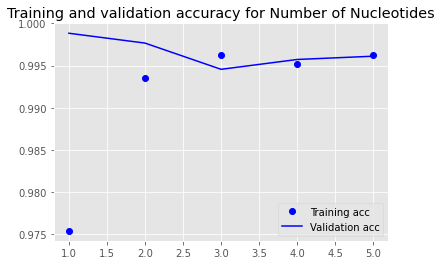

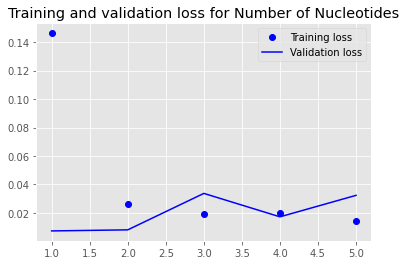

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.style.use('ggplot')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for Number of Nucleotides')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for Number of Nucleotides')
plt.legend()

plt.show()

In [98]:
# knn
error_rate = []
acc = []

K = range(1,40)
for k in K:
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    error_rate.append(np.mean(predictions != y_test))
    acc.append(metrics.accuracy_score(y_test, predictions))

Minimum error:- 0.0003885003885003885 at K = 3


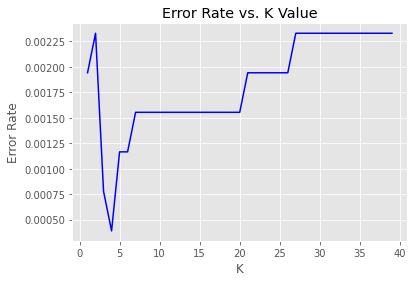

In [99]:
plt.style.use('ggplot')
plt.plot(K, error_rate, 'b', label='error')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.9996114996114996 at K = 3


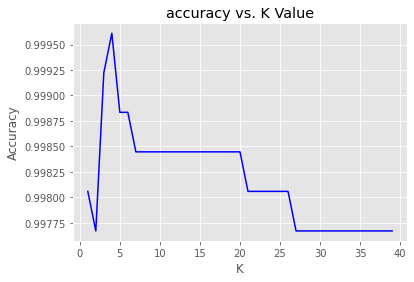

In [100]:
plt.plot(K, acc, 'b', label='acc')
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

<AxesSubplot:>

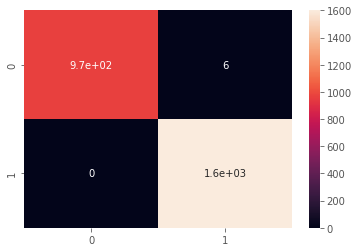

In [101]:
# confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(conf_matrix, annot=True)